# Cel projektu
Celem projektu jest opracowanie modelu predykcyjnego Long-Short Term Memory (LSTM), który oszacuje za pomocą regresji liniowej wartość kursu BTCUSD na podstawie wprowadzonych danych wejściowych z innych instrumentów.

Następnie, model zostanie porównany z predykcją średniej kroczącej, a także zmodyfikowany do działania wyłącznie na podstawie kursu BTCUSD. Metryki wykorzystane do oceny jakości to Mean Squared Error (MSE) oraz Mean Absolute Error (MAE).

Ostatnim etapem projektu jest wprowadzenie elementu generalizacji za pomocą innych danych dotyczących. Nowymi danymi wejściowymi i wyjściowymi będzie kurs NASDAQ.

# 1. Wczytanie danych

In [2]:
import pandas as pd
from siml_data import Featureset

In [3]:
feature_loader = Featureset()

In [4]:
df = feature_loader.get()

## Sprawdzenie typów i wartości nienumerycznych

In [5]:
df.isna().sum().sum()

0

In [6]:
df.dtypes

GCM24Open        float64
GCM24High        float64
GCM24Low         float64
GCM24Close       float64
IXICOpen         float64
IXICHigh         float64
IXICLow          float64
IXICClose        float64
HKDOpen          float64
HKDHigh          float64
HKDLow           float64
HKDClose         float64
GXCOpen          float64
GXCHigh          float64
GXCLow           float64
GXCClose         float64
CNYOpen          float64
CNYHigh          float64
CNYLow           float64
CNYClose         float64
GSPCOpen         float64
GSPCHigh         float64
GSPCLow          float64
GSPCClose        float64
CLK24Open        float64
CLK24High        float64
CLK24Low         float64
CLK24Close       float64
MCHIOpen         float64
MCHIHigh         float64
MCHILow          float64
MCHIClose        float64
0386Open         float64
0386High         float64
0386Low          float64
0386Close        float64
BLKOpen          float64
BLKHigh          float64
BLKLow           float64
BLKClose         float64


## Filtrowanie po cenie zamknięcia

In [7]:
[x for x in df.columns if 'btc' in x.lower()]

['btcusd_dOpen', 'btcusd_dHigh', 'btcusd_dLow', 'btcusd_dClose']

In [8]:
df = df.drop(columns=[c for c in df.columns if 'Close' not in c])

## Korelacja

<Axes: >

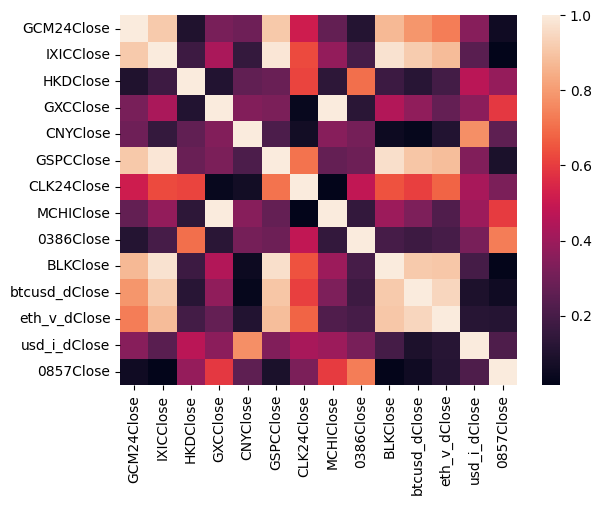

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr().abs()
sns.heatmap(corr)

In [10]:
corr['btcusd_dClose'].sort_values(ascending=False).head(10)

btcusd_dClose    1.000000
eth_v_dClose     0.945606
IXICClose        0.916503
BLKClose         0.912576
GSPCClose        0.902721
GCM24Close       0.786737
CLK24Close       0.605982
GXCClose         0.372193
MCHIClose        0.327378
0386Close        0.173504
Name: btcusd_dClose, dtype: float64

## Selekcja danych wejściowych

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [12]:
regressor = LinearRegression()
regressor.fit(df.drop(columns=['btcusd_dClose']).values, df['btcusd_dClose'].values)

LinearRegression()

In [13]:
feature_names = df.drop(columns=['btcusd_dClose']).columns
feature_coef = np.log(np.abs(regressor.coef_)) + 1
feature_relevance = pd.DataFrame(
    {k:[v, corr.loc[k, 'btcusd_dClose']] for k,v in zip(feature_names, feature_coef)}).T.rename(
    columns={0:'coef', 1:'corr'})

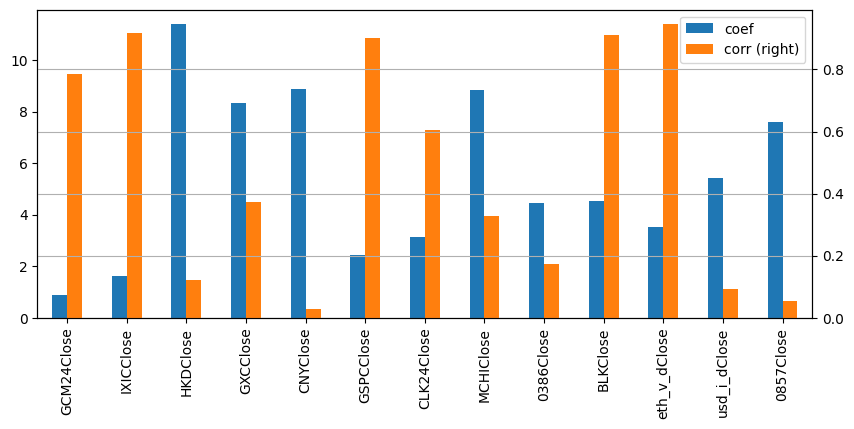

In [14]:
feature_relevance.plot(kind='bar', secondary_y='corr', figsize=(10,4))
plt.grid()

In [15]:
feature_relevance.describe()

,coef,corr
count,13.000000,13.000000
mean,5.464663,0.479818
std,3.252491,0.373876
min,0.871712,0.028453
25%,3.137622,0.119805
50%,4.512128,0.372193
75%,8.332120,0.902721
max,11.386364,0.945606


In [16]:
threshold = {'coef':3.2, 'corr':0.9}
best_features = (feature_relevance['coef'] > threshold['coef']) | (feature_relevance['corr'] > threshold['corr'])
selected_features = best_features[best_features.values].index.tolist()
selected_features

['IXICClose',
 'HKDClose',
 'GXCClose',
 'CNYClose',
 'GSPCClose',
 'MCHIClose',
 '0386Close',
 'BLKClose',
 'eth_v_dClose',
 'usd_i_dClose',
 '0857Close']

## Utworzenie zbiorów uczących

In [17]:
from siml_pipeline import Pipeline

In [18]:
p = Pipeline()
X_train, X_test, Y_train, Y_test = p.process(df[selected_features + ['btcusd_dClose']], 'btcusd_dClose')

In [19]:
n_of_features = X_train.shape[-1]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1240, 10, 11), (407, 10, 11), (1240, 1), (407, 1))

# 2. Trenowanie modelu LSTM

In [20]:
from siml_model import build_model

In [21]:
model = build_model(p.num_days, n_of_features)

2024-05-14 21:04:40.161067: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 21:04:40.163217: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Liczba trenowalnych parametrów powinna mieć podobny rząd wartości co rozmiar zbioru uczącego.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 24)            3456      
_________________________________________________________________
dropout (Dropout)            (None, 10, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 12)            1776      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 12)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 6)             456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 6)             0         
_________________________________________________________________
flatten (Flatten)            (None, 60)                0

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [24]:
epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch)

2024-05-14 21:04:41.651183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
39/39 [==============================] - 5s 36ms/step - loss: 0.8654 - mae: 0.5745 - val_loss: 2.1851 - val_mae: 1.2625
Epoch 2/10
39/39 [==============================] - 1s 24ms/step - loss: 0.5293 - mae: 0.4216 - val_loss: 1.4896 - val_mae: 0.9790
Epoch 3/10
39/39 [==============================] - 1s 24ms/step - loss: 0.1701 - mae: 0.2586 - val_loss: 1.2671 - val_mae: 0.8611
Epoch 4/10
39/39 [==============================] - 1s 24ms/step - loss: 0.1544 - mae: 0.2314 - val_loss: 1.2549 - val_mae: 0.8566
Epoch 5/10
39/39 [==============================] - 1s 27ms/step - loss: 0.1286 - mae: 0.2130 - val_loss: 1.2555 - val_mae: 0.8505
Epoch 6/10
39/39 [==============================] - 1s 22ms/step - loss: 0.1209 - mae: 0.2086 - val_loss: 1.1844 - val_mae: 0.8145
Epoch 7/10
39/39 [==============================] - 1s 24ms/step - loss: 0.1093 - mae: 0.1992 - val_loss: 1.1619 - val_mae: 0.8003
Epoch 8/10
39/39 [==============================] - 1s 25ms/step - loss: 0.1065 - m

## Wyniki trenowania
Historia wartości MSE (loss) oraz dodatkowej metryki MAE na zbiorze trenującym i testowym (val).

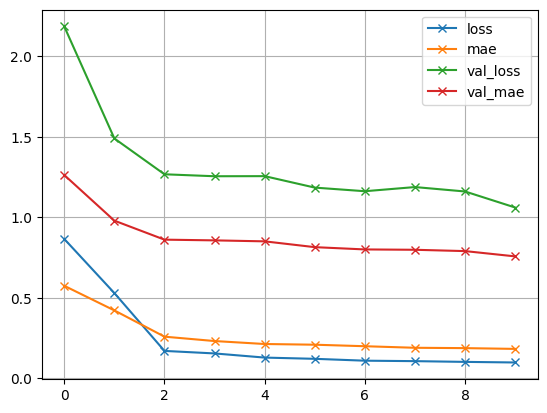

In [25]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

# 3. Ewaluacja modelu

In [31]:
MA = df.rolling(window=10).mean().rename(columns=lambda n: n.replace('Close', 'MA'))

In [27]:
btc_hat = p.restore(model.predict(np.vstack([X_train, X_test]))).ravel()
btc_hat = pd.Series(btc_hat, name='prediction', index=df.index[:len(btc_hat)])

In [28]:
btc = pd.concat([df['btcusd_dClose'], MA['btcusd_dMA'], btc_hat], axis=1)

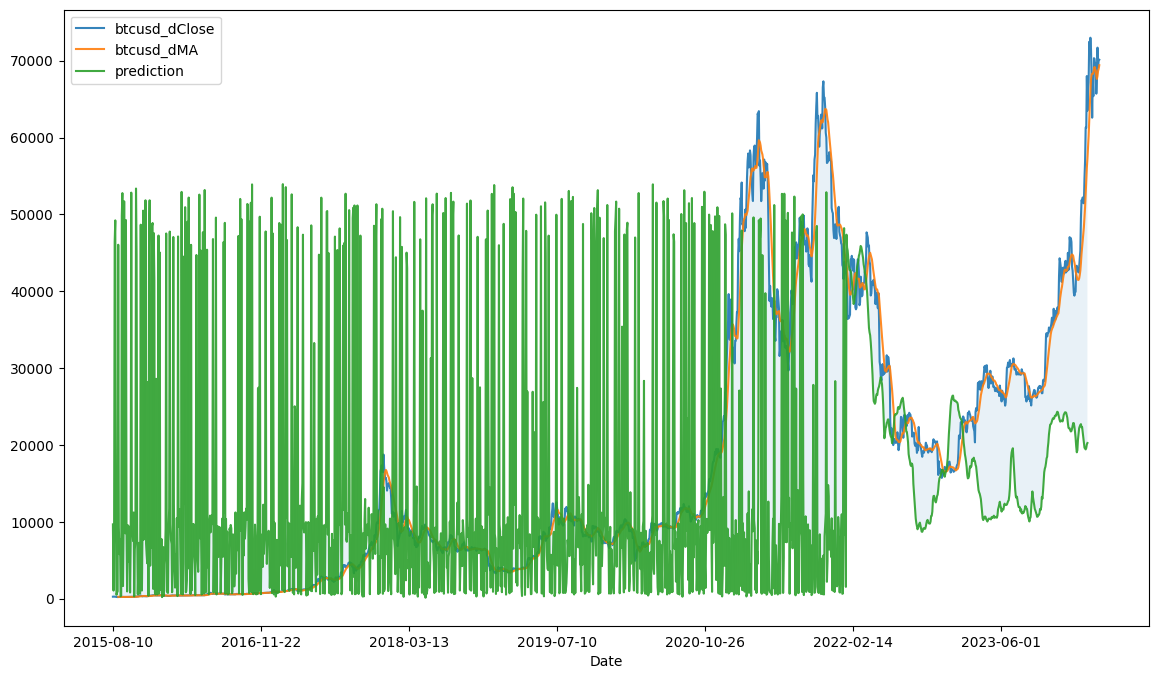

In [29]:
btc.plot(figsize=(14,8), style='-', alpha=0.9)
plt.fill_between(btc.index, btc['prediction'], btc['btcusd_dClose'], alpha=0.1)

<Axes: >

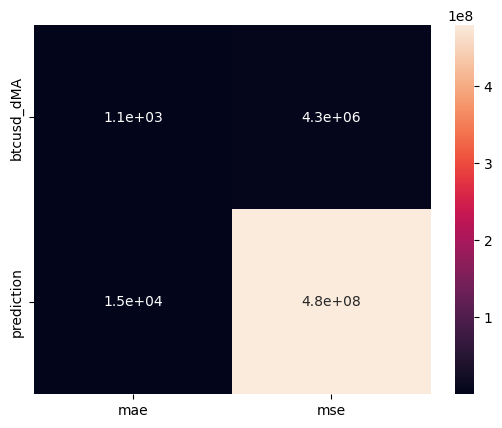

In [30]:
err = btc - pd.concat([btc['btcusd_dClose']] * 3, axis=1).values
err.drop('btcusd_dClose', axis=1, inplace=True)
mae = err.abs().mean()
mse = (err ** 2).mean()
sns.heatmap(pd.DataFrame({'mae':mae, 'mse':mse}), annot=True)

## Predykcja na podstawie samego kursu

In [33]:
from siml_pipeline import SingleFeaturePipeline
ONE_FEATURE = 1

In [34]:
sp = SingleFeaturePipeline()
X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])

In [35]:
model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 24)            2496      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 24)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 12)            1776      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 12)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 6)             456       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 6)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)               

In [37]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch,
                    callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
40/40 [==============================] - 4s 34ms/step - loss: 0.9524 - mae: 0.8127 - val_loss: 1.1413 - val_mae: 0.8261
Epoch 2/10
40/40 [==============================] - 1s 23ms/step - loss: 0.7721 - mae: 0.6049 - val_loss: 1.0704 - val_mae: 0.7786
Epoch 3/10
40/40 [==============================] - 1s 22ms/step - loss: 0.5576 - mae: 0.4348 - val_loss: 0.7818 - val_mae: 0.5790
Epoch 4/10
40/40 [==============================] - 1s 20ms/step - loss: 0.3942 - mae: 0.3282 - val_loss: 0.5599 - val_mae: 0.4850
Epoch 5/10
40/40 [==============================] - 1s 24ms/step - loss: 0.2769 - mae: 0.2728 - val_loss: 0.3848 - val_mae: 0.4011
Epoch 6/10
40/40 [==============================] - 1s 20ms/step - loss: 0.2049 - mae: 0.2438 - val_loss: 0.2992 - val_mae: 0.3557
Epoch 7/10
40/40 [==============================] - 1s 20ms/step - loss: 0.1596 - mae: 0.2233 - val_loss: 0.2224 - val_mae: 0.3609
Epoch 8/10
40/40 [==============================] - 1s 22ms/step - loss: 0.1064 - m

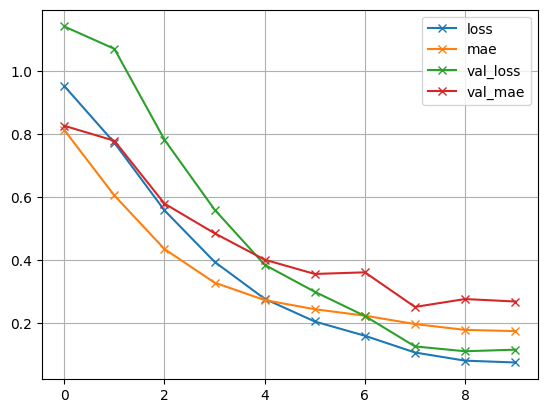

In [39]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

## Grid Search
Optymalizacja parametrów batch_size, num_days, look_ahead.

In [40]:
batch_size_domain = [2, 4, 8, 16, 32, 64, 128, 256]
num_days_domain = [10, 12, 14, 16, 18, 20]
look_ahead_domain = [2, 4, 6, 8, 10]

In [64]:
domain = []
for bs in batch_size_domain:
    for nd in num_days_domain:
        for la in look_ahead_domain:
            domain.append({'batch_size': bs, 'num_days': nd, 'look_ahead': la})
domain = np.array(domain)
len(domain)

240

In [66]:
FRACTION = 0.1
sample_size = int(len(domain) * FRACTION)
domain_sample = np.hstack([np.zeros(len(domain) - sample_size), np.ones(sample_size)])
np.random.shuffle(domain_sample)
domain = domain[domain_sample.astype(bool)]
len(domain)

16

In [67]:
def evaluate_model(num_days=10, look_ahead=8, batch_size=32, epochs=10):
    sp = SingleFeaturePipeline(num_days=num_days, look_ahead=look_ahead)
    X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])
    model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    history = model.fit(X_train,
                        Y_train,
                        validation_data=(X_test, Y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EarlyStopping(patience=2)],
                        verbose=0)
    return history.history['val_loss'][-1]

In [68]:
grid_search = []
for params in domain:
    grid_search.append({'params':params, 'result':evaluate_model(**params)})
grid_search = pd.DataFrame(grid_search)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.3976 - mae: 0.4480 - val_loss: 0.1220 - val_mae: 0.2733
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0914 - mae: 0.1859 - val_loss: 0.1894 - val_mae: 0.3514
Epoch 3/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0678 - mae: 0.1674 - val_loss: 0.2818 - val_mae: 0.4583
Epoch 1/10
625/625 [==============================] - 11s 15ms/step - loss: 0.4457 - mae: 0.5581 - val_loss: 0.1073 - val_mae: 0.2629
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1263 - mae: 0.2837 - val_loss: 0.1170 - val_mae: 0.2668
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.0679 - mae: 0.1951 - val_loss: 0.1175 - val_mae: 0.2839
Epoch 1/10
625/625 [==============================] - 13s 19ms/step - loss: 0.1799 - mae: 0.2593 - val_loss: 0.0373 - val_mae: 0.1690
Epoch 2/10
625/625 [==============================] - 12s 19ms/ste

In [69]:
grid_search

,params,result
0,"{'batch_size': 2, 'num_days': 12, 'look_ahead'...",0.281784
1,"{'batch_size': 2, 'num_days': 14, 'look_ahead'...",0.117508
2,"{'batch_size': 2, 'num_days': 18, 'look_ahead'...",0.011376
3,"{'batch_size': 2, 'num_days': 18, 'look_ahead'...",0.106054
4,"{'batch_size': 2, 'num_days': 20, 'look_ahead'...",0.038072
5,"{'batch_size': 4, 'num_days': 18, 'look_ahead'...",0.019633
6,"{'batch_size': 4, 'num_days': 20, 'look_ahead'...",0.036742
7,"{'batch_size': 8, 'num_days': 14, 'look_ahead'...",0.037451
8,"{'batch_size': 8, 'num_days': 14, 'look_ahead'...",0.192254
9,"{'batch_size': 8, 'num_days': 14, 'look_ahead'...",0.234252


## Zapis do pliku

# 4. Generalizacja
Ewaluacja modelu na danych indeksu NASDAQ.

> Nie wymaga wcześniejszego wykonania poprzednich etapów pod warunkiem istnienia zapisanego modelu.

In [ ]:
from siml_data import Featureset

feature_loader = Featureset()
df = feature_loader.get()

In [ ]:
from siml_pipeline import SingleFeaturePipeline
ONE_FEATURE = 1

sp = SingleFeaturePipeline()
X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])